In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from skimage.color import label2rgb
from tifffile import imread
from os import listdir, makedirs

from yoeo.main import get_dv2_model, get_upsampler_and_expr, get_hr_feats, get_lr_feats, convert_image, closest_crop
from yoeo.utils import to_numpy

from interactive_seg_backend import featurise_
from interactive_seg_backend.configs import FeatureConfig, TrainingConfig, CRFParams
from interactive_seg_backend.classifiers.base import Classifier
from interactive_seg_backend.file_handling import load_labels, load_image, save_segmentation
from interactive_seg_backend.core import train, get_training_data, shuffle_sample_training_data, get_model
from interactive_seg_backend.core import apply_
from interactive_seg_backend.main import apply
from interactive_seg_backend.utils import class_avg_miou

from is_helpers import train_model_over_images, apply_model_over_images, eval_preds

import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgba


from typing import Literal

SEED = 10672
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda:1"

N CPUS: 110


In [2]:
cmap = [
            "#fafafa",
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
        ]
color_list = [[255, 255, 255], [31, 119, 180], [255, 127, 14], [44, 160, 44], [255, 0, 0]]
COLORS = np.array(color_list) / 255.0

In [3]:
dv2 = get_dv2_model(True, device=DEVICE)

model_path = "../trained_models/e5000_full_fit_reg.pth"
cfg_path = "../yoeo/models/configs/combined_no_shift.json"

upsampler, expr = get_upsampler_and_expr(model_path, cfg_path, device=DEVICE)

Using cache found in /home/ronan/.cache/torch/hub/ywyue_FiT3D_main


In [7]:
PATH = "fig_data/is_benchmark"
AllowedDatasets = Literal["Ni_superalloy_SEM", "T_cell_TEM", "Cu_ore_RLM"]
dataset: tuple[AllowedDatasets, ...] = ("Ni_superalloy_SEM", "T_cell_TEM", "Cu_ore_RLM")

TRAIN_IMG_FNAMES: dict[AllowedDatasets, list[str]] = {"Cu_ore_RLM": ["001", "028", "049", "068"], 
                                                      "Ni_superalloy_SEM": ["000", "001", "005", "007"], 
                                                      "T_cell_TEM": ["000", "027", "021", "105"]
                                                      }

all_classical_preds: dict[AllowedDatasets, dict[str, np.ndarray]] = {k: {} for k in dataset}
all_deep_preds: dict[AllowedDatasets, dict[str, np.ndarray]] = {k: {} for k in dataset}

In [8]:
# chosen_dataset: AllowedDatasets = "Ni_superalloy_SEM"

In [9]:
for ds_name in dataset[:2]:
    chosen_dataset = ds_name
    feat_cfg = FeatureConfig()

    classical_train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=False, classifier='xgb', classifier_params = {"class_weight": "balanced"},)
    classical_model, _ = train_model_over_images(chosen_dataset, classical_train_cfg, PATH, TRAIN_IMG_FNAMES[chosen_dataset], dv2, upsampler, expr)

    deep_train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=True, classifier='xgb', classifier_params = {"class_weight": "balanced"},)
    deep_model, pca = train_model_over_images(chosen_dataset, deep_train_cfg, PATH, TRAIN_IMG_FNAMES[chosen_dataset], dv2, upsampler, expr)

    classical_preds = apply_model_over_images(chosen_dataset, classical_train_cfg, classical_model, PATH, dv2, upsampler, expr, verbose=True)
    deep_preds = apply_model_over_images(chosen_dataset, deep_train_cfg, deep_model, PATH, dv2, upsampler, expr, verbose=True, existing_pca=pca)

    all_classical_preds[ds_name] = classical_preds
    all_deep_preds[ds_name] = deep_preds


    miou_classical = eval_preds(chosen_dataset, classical_preds, PATH)
    miou_deep = eval_preds(chosen_dataset, deep_preds, PATH )
    print(f"======== {ds_name} ========")
    print(f"mIoU_classical: {miou_classical} vs mIoU_deep: {miou_deep}\n")

Finished featurising
Finished featurising
[00/23] - 000.tif
[10/23] - 010.tif
[20/23] - 020.tif
[00/23] - 000.tif
[10/23] - 010.tif
[20/23] - 020.tif
======== Ni_superalloy_SEM ========
mIoU_classical: 0.540583074226783 vs mIoU_deep: 0.6957635179498791

Finished featurising
Finished featurising
[00/30] - 000.tif
[10/30] - 044.tif
[20/30] - 076.tif
[00/30] - 000.tif
[10/30] - 044.tif
[20/30] - 076.tif
======== T_cell_TEM ========
mIoU_classical: 0.39013339317488605 vs mIoU_deep: 0.6631119550164688



In [10]:
# feat_cfg = FeatureConfig()

# classical_train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=False, classifier='xgb', classifier_params = {"class_weight": "balanced"},)
# classical_model, _ = train_model_over_images(chosen_dataset, classical_train_cfg, PATH, TRAIN_IMG_FNAMES[chosen_dataset], dv2, upsampler, expr)

# deep_train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=True, classifier='xgb', classifier_params = {"class_weight": "balanced"},)
# deep_model, pca = train_model_over_images(chosen_dataset, deep_train_cfg, PATH, TRAIN_IMG_FNAMES[chosen_dataset], dv2, upsampler, expr)

In [11]:
# classical_preds = apply_model_over_images(chosen_dataset, classical_train_cfg, classical_model, PATH, dv2, upsampler, expr, verbose=True)
# deep_preds = apply_model_over_images(chosen_dataset, deep_train_cfg, deep_model, PATH, dv2, upsampler, expr, verbose=True, existing_pca=pca)

In [12]:
# SAVE = True
# if SAVE:
#     classical_folder = f"{PATH}/{chosen_dataset}/preds/classical"
#     deep_folder = f"{PATH}/{chosen_dataset}/preds/deep"
#     makedirs(classical_folder, exist_ok=True)
#     makedirs(deep_folder, exist_ok=True)

#     for folder, pred_dict in zip((classical_folder, deep_folder), (classical_preds, deep_preds)):
#         for fname, seg in pred_dict.items():
#             save_segmentation(seg, f"{folder}/{fname}")

In [13]:
TITLE_FS = 25
LABEL_FS = 23
TICK_FS = 21
PAD = 60

def hide_axis_ticks(ax, frameoff: bool=True):
    ax.tick_params(which="both", bottom=False, top=False, left=False, right=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    if frameoff:
        ax.set_frame_on(False)


def add_stacked_rects(fig, subplot):
    outer_pos = subplot.get_position(fig) 

    x0, y0 = outer_pos.x0, outer_pos.y0
    width, height = outer_pos.width, outer_pos.height

    # Base color
    base_color = np.array(to_rgba('#bbbbbb'))

    for n in range(3):  # 3 stacked layers
        T = 0.005
        offset = n * T  # tweak this for separation between layers
        darken = 0.05 * n   # tweak this for how much darker each layer is
        color = np.clip(base_color - darken, 0, 1)  # slightly darker with each layer

        rect = Rectangle(
            (x0 + T + offset, y0 + T + offset),  # move up and right a bit
            width , height,
            transform=fig.transFigure,
            color=color,
            zorder=-n - 1,  # stack order: bottom first
            alpha=1,
            linewidth=1,
            edgecolor='black'
        )
        fig.patches.append(rect)

plt.rcParams["font.family"] = "serif"

In [14]:
%%capture
img_paths = sorted(listdir(f"{PATH}/{chosen_dataset}/images"))[::5]

n_samples = len(img_paths)
fig, axs = plt.subplots(nrows=4, ncols=n_samples)

fig.set_size_inches((18, 16))


for i, img_fname in enumerate(img_paths):
    img = imread(f"{PATH}/{chosen_dataset}/images/{img_fname}")
    gt_seg = imread(f"{PATH}/{chosen_dataset}/segmentations/{img_fname}")

    classical_pred = classical_preds[img_fname]
    deep_pred = deep_preds[img_fname]

    ax0, ax1, ax2, ax3 = axs[: ,i]
    ax0.imshow(img, cmap='binary_r')
    ax1.imshow(label2rgb(gt_seg, colors=COLORS[1:]))
    ax2.imshow(label2rgb(classical_pred + 1, colors=COLORS[1:]))
    ax3.imshow(label2rgb(deep_pred + 1, colors=COLORS[1:]))

    if i == 0:
        ax0.set_ylabel('Image', fontsize=TITLE_FS)
        ax1.set_ylabel('Ground truth', fontsize=TITLE_FS)
        ax2.set_ylabel('Classical', fontsize=TITLE_FS)
        ax3.set_ylabel('+ HR ViT features', fontsize=TITLE_FS)
    
    ax0.set_title(img_fname, fontsize=TITLE_FS)

    for ax in (ax0, ax1, ax2, ax3):
        hide_axis_ticks(ax)

plt.tight_layout()

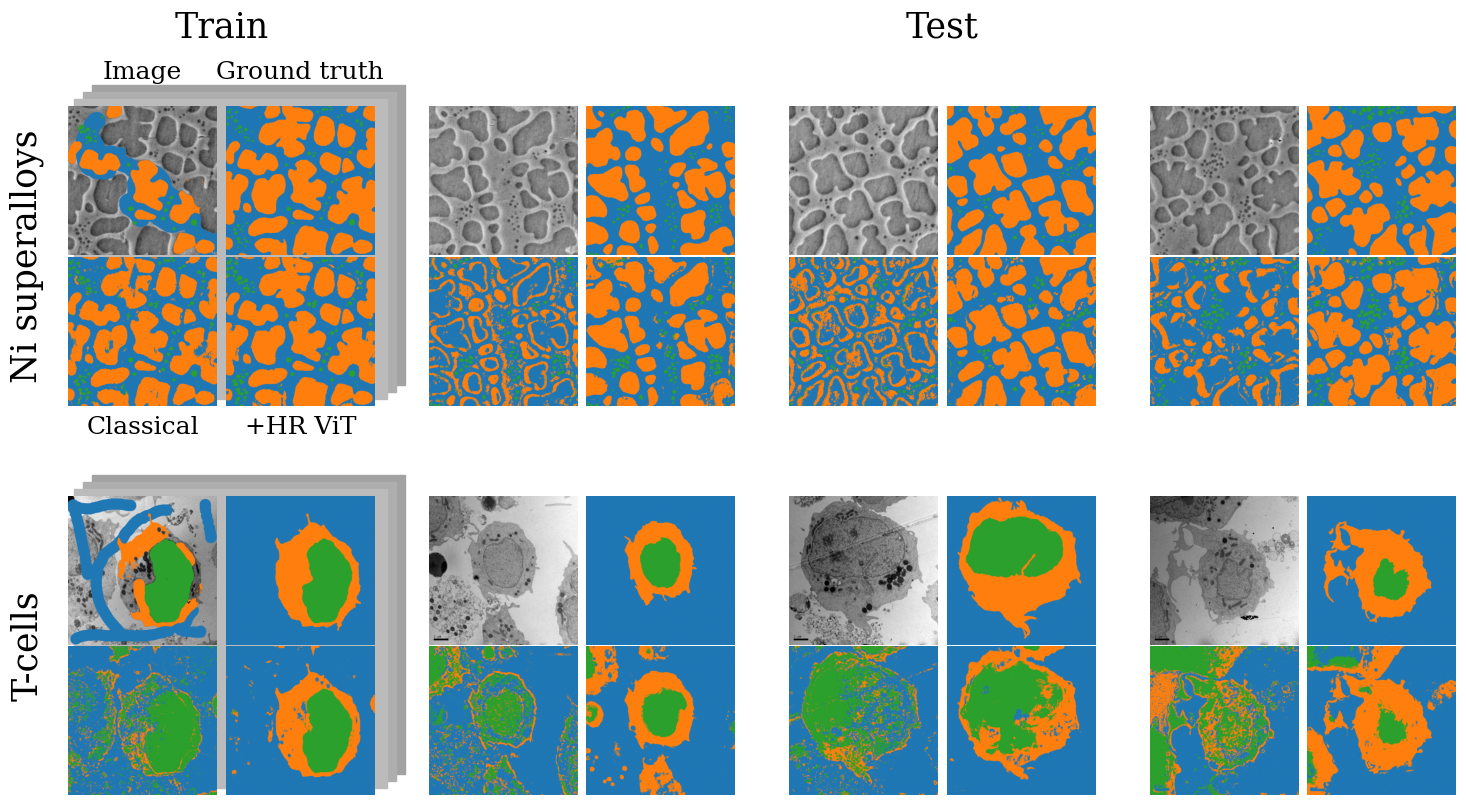

In [16]:
# %%capture
datasets: list[AllowedDatasets] = ["Ni_superalloy_SEM"] 
titles = ["Ni superalloys", "T-cells", "Cu ore"]



def do_fourplot(dataset: AllowedDatasets, filename: str, parent_grid, classical_preds: dict[str, np.ndarray], deep_preds: dict[str, np.ndarray],  is_train: bool, is_top_left_corner: bool = False):
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2,
                subplot_spec=parent_grid, wspace=0.01, hspace=0.01)

    for k in range(4):  # Each image (original + 3 derivatives)
        ax = plt.Subplot(fig, inner_grid[k // 2, k % 2])
        # ax.imshow(datasets[i][j][k], cmap='gray')
        hide_axis_ticks(ax)
        fig.add_subplot(ax)

        if is_very_top_corner and k < 2:
            ax.set_title(subfig_titles[k], fontsize=LABEL_FS-5, pad=20)
        elif is_very_top_corner and k >= 2:
            ax.set_xlabel(subfig_titles[k], fontsize=LABEL_FS-5, labelpad=0)
        
        if k == 0:
            img = imread(f"{PATH}/{dataset}/images/{filename}")

            if is_train:
                labels = imread(f"{PATH}/{dataset}/labels/{filename}")
                labels_unsqueezed = np.expand_dims(labels[0], -1)

                overlay = label2rgb(labels[0], colors=COLORS[1:], kind='overlay', bg_label=0, image_alpha=1, alpha=1)
                out = np.where(labels_unsqueezed, overlay * 255, np.expand_dims(img, -1)).astype(np.uint8)
                img_with_labels = Image.fromarray(out)

                ax.imshow(img_with_labels, cmap='binary_r')
            else:
                ax.imshow(img, cmap='binary_r')

        elif k == 1:
            gt_seg = imread(f"{PATH}/{dataset}/segmentations/{filename}")
            ax.imshow(label2rgb(gt_seg, colors=COLORS[1:]))
        elif k == 2:
            classical_seg = classical_preds[f"{filename}"]
            ax.imshow(label2rgb(classical_seg + 1, colors=COLORS[1:]))
        elif k == 3:
            deep_seg = deep_preds[f"{filename}"]
            ax.imshow(label2rgb(deep_seg + 1, colors=COLORS[1:]))


fig = plt.figure(figsize=(18, 14))
outer_grid = gridspec.GridSpec(3, 4, wspace=0.15, hspace=0.3)  # 3 rows (datasets), 4 columns (examples per dataset)
train_img_idx = [2, 0, 1]
rev = [True, False, True]

for i in range(2):  # Dataset rows
    chosen_dataset = list(all_classical_preds.keys())[i]
    train_filenames = TRAIN_IMG_FNAMES[chosen_dataset]
    test_img_fnames = [f for f in sorted(listdir(f"{PATH}/{chosen_dataset}/images")) if f not in train_filenames]
    if rev[i]:
        test_img_fnames = test_img_fnames[::-1]

    ax_train_label = plt.Subplot(fig, outer_grid[i, 0])
    ax_train_label.set_ylabel(titles[i], fontsize=TITLE_FS, labelpad=PAD-40, rotation=90, va='center')
    ax_test_label = plt.Subplot(fig, outer_grid[i, 2])
    if i == 0:
        ax_train_label.set_title('Train', fontsize=TITLE_FS, pad=PAD-10)
        ax_test_label.set_title('Test', fontsize=TITLE_FS, pad=PAD-10)

    add_stacked_rects(fig, outer_grid[i, 0])
    hide_axis_ticks(ax_train_label)
    fig.add_subplot(ax_train_label)
    hide_axis_ticks(ax_test_label)
    fig.add_subplot(ax_test_label)

    outer_pos = outer_grid[i, 0].get_position(fig)
    # Coordinates of the 2x2 block to be used as background
    x0, y0 = outer_pos.x0, outer_pos.y0
    width, height = outer_pos.width, outer_pos.height

    subfig_titles = ["Image", "Ground truth", "Classical", '+HR ViT']

    # chosen_dataset = "Ni_superalloy_SEM" #datasets[i]
    img_fnames = sorted(listdir(f"{PATH}/{chosen_dataset}/images"))
    seg_fnames = sorted(listdir(f"{PATH}/{chosen_dataset}/segmentations"))

    train_example = train_filenames[train_img_idx[i]] + '.tif'

    for j in range(4):  # 4 examples per dataset

        is_very_top_corner = i == 0 and j == 0
        is_train_example = j == 0

        example_fname = train_example if j == 0 else test_img_fnames[j]

        do_fourplot(chosen_dataset, example_fname, outer_grid[i, j], all_classical_preds[chosen_dataset], all_deep_preds[chosen_dataset], is_train_example, is_very_top_corner)


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make space for suptitle
plt.savefig('fig_out/is_benchmark.png' ,bbox_inches='tight')